In [15]:
import json
import astropy.units as u
import matplotlib.pyplot as plt

from gammapy.datasets import MapDataset
from gammapy.modeling.models import Models
from gammapy.estimators import ExcessMapEstimator, FluxPoints

from GPyUtils.models_templates import MyCatalog
from modules.variables import *

# Specify the folder containing your JSON files
diffuse = 'no_diffuse'
file_name = 'all_IDs'
strategy = 1
tol = 0.1
e_min = 1
e_max = 200
bin = 20
binsz = 0.02
jsons_path = path_to_results / 'multi_models' / f'strategy_{strategy}' / f'tol_{tol}' / diffuse / f"{file_name}_ene_{e_min}_{e_max}_bin_{bin}_binsz_{binsz}" / "jsons"

# Initialize empty lists to store the data for plotting
names = []
successes = []
values = []


In [16]:
# Iterate through the JSON files in the folder
paths = list(jsons_path.rglob("*.json"))
paths.sort()
for file_path in paths:
    # Load the JSON data from the file
        with file_path.open('r') as file:
            data = json.load(file)
            name = list(data.keys())[0]
            if file_path.with_suffix('').name == 'nullhypothesis_fitted':
                L0 = data[name]['Nullhypothesis']['result'][-1]
            elif file_path.with_suffix('').name == '00_template_fitted':
                # Extract the relevant data
                success = data[name]['fermi bubble']['result'][0]
                value = data[name]['fermi bubble']['result'][-1] 
            else:
                # Extract the relevant data
                success = data[name]['cygnus_diffuse']['result'][0]
                value = data[name]['cygnus_diffuse']['result'][-1]

                # Append the data to the lists
                names.append(name)
                successes.append(success)
                values.append(value)

TS = [L0 - L1 for L1 in values]

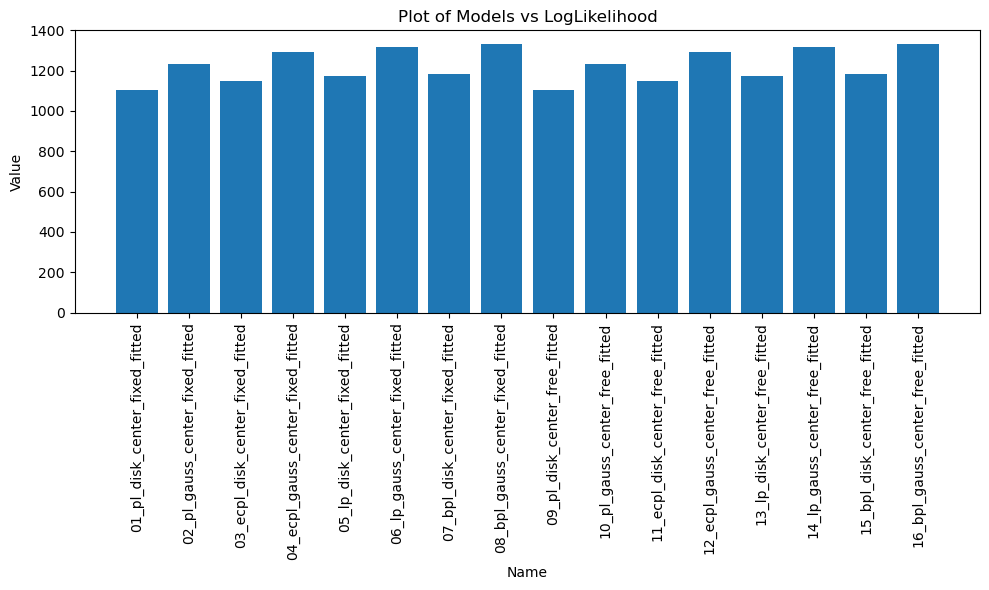

[True, True, True, True, True, True, False, False, True, True, True, True, True, True, False, False]


In [17]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(names, TS)
#plt.yscale('log')
#plt.ylim(-6.883e6,-6.881e6)
#plt.ylim(-7.825e6,-7.84e6)
#plt.ylim(1600,1700)
plt.xlabel('Name')
plt.ylabel('Value')
plt.title('Plot of Models vs LogLikelihood')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()
print(successes)

In [18]:
# Set the path to the dataset file
dataset_name = f"dataset_{file_name}_ene_{e_min}_{e_max}_bin_{bin}_binsz_{binsz}.fits.gz"
path_to_dataset = path_to_datasets / 'width_22x10' / dataset_name

# Reading the MapDataset from the specified file
dataset = MapDataset.read(filename=path_to_dataset)

In [19]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[1, 5, 10, 20, 50, 100] * u.TeV,
)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/home/tutone/Installed/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/tutone/Installed/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/tutone/Installed/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


08_bpl_gauss_center_fixed_fitted


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/home/tutone/Installed/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/tutone/Installed/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/tutone/Installed/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use 

Text(0.5, 1.0, '$\\sqrt{TS}$ Map')

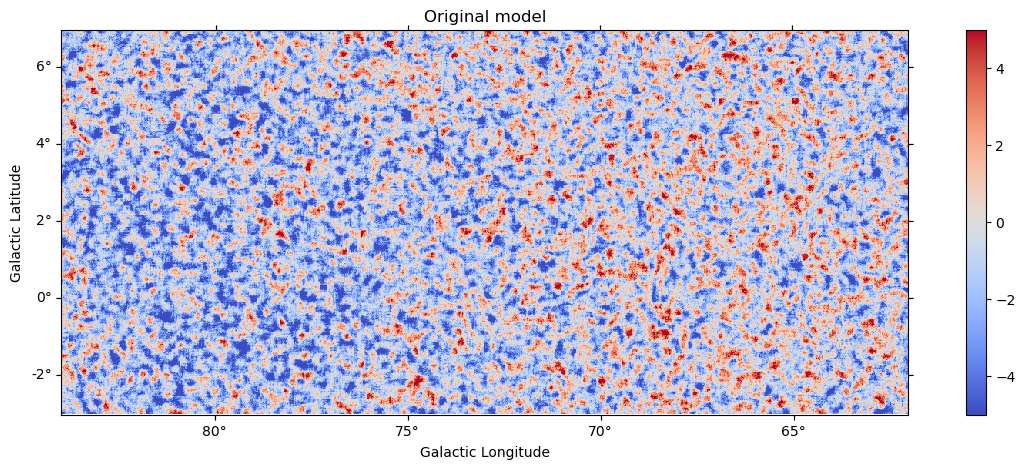

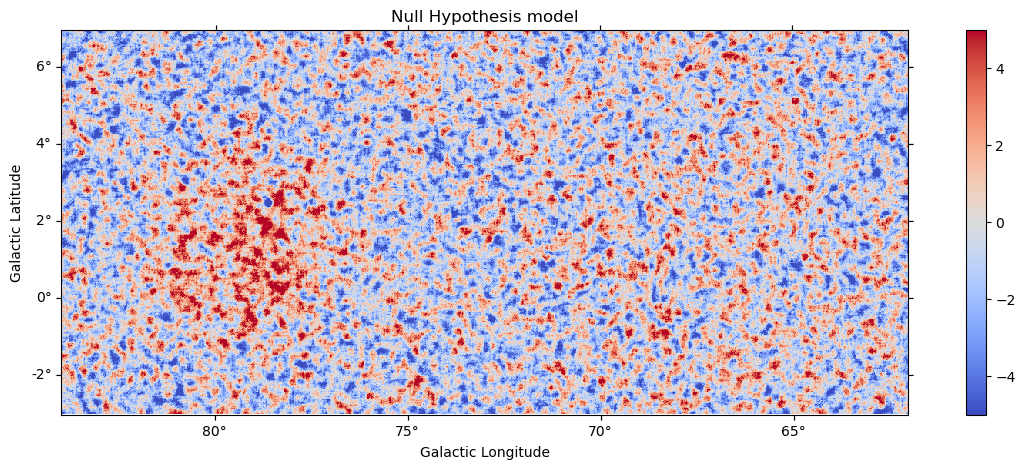

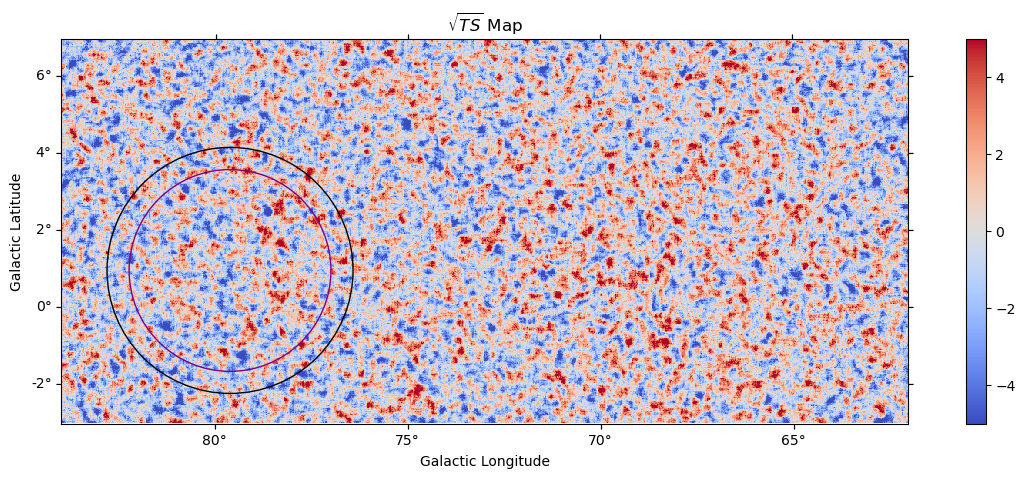

In [20]:
original_model_path = dc_folder / 'skymodel' / 'global_skymodel_v1.0.yaml'
original_model = Models.read(original_model_path)

dataset.models = original_model
fermi_spatial_model = dataset.models["fermi bubble"].spatial_model
true_result = estimator.run(dataset)

# Name of the YAML file containing the fitted model to be used for the SED calculation
filename = names[TS.index(max(TS))]
print(filename)
path_to_fit_models = path_to_results / 'multi_models' / f'strategy_{strategy}' / f'tol_{tol}' / diffuse / f"{file_name}_ene_{e_min}_{e_max}_bin_{bin}_binsz_{binsz}" / "models"

# Load the fitted Null Hypothesis model from the YAML file
nullhypths_fit = Models.read(f"{path_to_fit_models}/nullhypothesis_fitted.yaml")
# Set the loaded model as the source model in the dataset
dataset.models = nullhypths_fit
null_result = estimator.run(dataset)

# Load the fitted model from the YAML file
models_fit = Models.read(f"{path_to_fit_models}/{filename}.yaml")

# Set the loaded model as the source model in the dataset
dataset.models = models_fit
cygnus_diffuse_spatial_model = dataset.models["cygnus_diffuse"].spatial_model
diffuse_result = estimator.run(dataset)

plt.figure(figsize=(15, 5))
true_result["sqrt_ts"].sum_over_axes().plot(cmap="coolwarm", add_cbar=True, vmax=5, vmin=-5)
plt.title("Original model")

plt.figure(figsize=(15, 5))
null_result["sqrt_ts"].sum_over_axes().plot(cmap="coolwarm", add_cbar=True, vmax=5, vmin=-5)
plt.title("Null Hypothesis model")

plt.figure(figsize=(15,5))
diffuse_result["sqrt_ts"].sum_over_axes().plot(cmap="coolwarm", add_cbar=True, vmax=5, vmin=-5)
fermi_spatial_model.to_region().to_pixel(wcs = dataset.counts.geom.wcs).plot(color="black")
cygnus_diffuse_spatial_model.to_region().to_pixel(wcs = dataset.counts.geom.wcs).plot(color="purple")
plt.title(r"$\sqrt{TS}$ Map")

In [21]:
path_to_result_fluxpoints = path_to_fluxdatapoints / 'multi_models' / f'strategy_{strategy}' / f'tol_{tol}' / diffuse / f"{file_name}_ene_{e_min}_{e_max}_bin_{bin}_binsz_{binsz}"
diffuse_flux_points = FluxPoints.read(path_to_result_fluxpoints / f"{filename}.fits")

template = path_to_result_fluxpoints / "00_template_fitted.fits"
template_flux_points = FluxPoints.read(template)

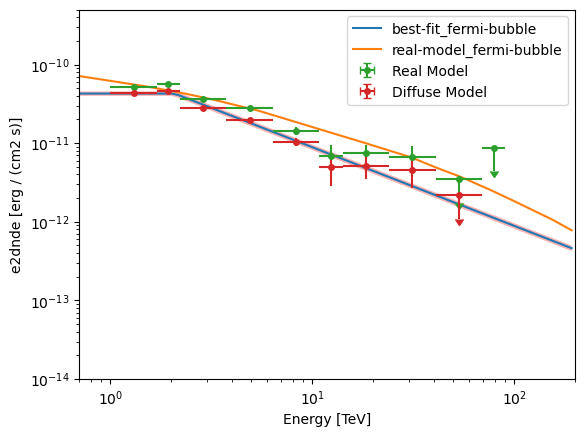

In [22]:
# Template emission for the Fermi Bubble
mycat = MyCatalog()
fermi_template = mycat.fermi_bubble()[0].spectral_model
fitted_diffuse = dataset.models["cygnus_diffuse"].spectral_model

fig, ax = plt.subplots()

plot_kwargs = {
    "energy_bounds": [0.1, 200] * u.TeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("erg cm-2 s-1"),
    "ax": ax,
}

# plot best fit model
fitted_diffuse.plot(**plot_kwargs, label="best-fit_fermi-bubble")
fitted_diffuse.plot_error(facecolor="red", alpha=0.3, **plot_kwargs)


# plot joint model
ax = fermi_template.plot(**plot_kwargs, label="real-model_fermi-bubble")

#plot flux data points
template_flux_points.plot(ax=ax, sed_type="e2dnde", label="Real Model")
diffuse_flux_points.plot(ax=ax, sed_type="e2dnde",label="Diffuse Model")

ax.set_ylim([1.e-14, 5.e-10])
ax.set_xlim([0.7, 200])
ax.legend()
plt.show()